In [216]:
%load_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm.notebook import tqdm

# from src.cache import cache

set_matplotlib_formats("svg")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [217]:
df = pd.read_csv("../../data/daily_data.csv", parse_dates=["date"])
df.shape

(15344, 41)

In [218]:
df["size_radical"] = np.log(df["size_radical"] + 1)
df["size_moderate"] = np.log(df["size_moderate"] + 1)

In [219]:
# add exponential rolling averages for columns 'size_radical', 'size_moderate', 'count_radical', 'count_moderate'
df = df.groupby("region").apply(
    lambda x: x.sort_values("date").assign(
        size_radical_ewm_month=lambda x: x["size_radical"].ewm(span=35).mean(),
        size_moderate_ewm_month=lambda x: x["size_moderate"].ewm(span=35).mean(),
        count_radical_ewm_month=lambda x: x["count_radical"].ewm(span=35).mean(),
        count_moderate_ewm_month=lambda x: x["count_moderate"].ewm(span=35).mean(),
        size_radical_ewm_year=lambda x: x["size_radical"].ewm(span=380).mean(),
        size_moderate_ewm_year=lambda x: x["size_moderate"].ewm(span=380).mean(),
        count_radical_ewm_year=lambda x: x["count_radical"].ewm(span=380).mean(),
        count_moderate_ewm_year=lambda x: x["count_moderate"].ewm(span=380).mean(),
    )
)

/tmp/ipykernel_11369/2579751802.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby("region").apply(


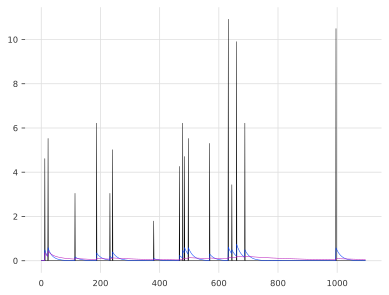

In [220]:
berlin = df.query("region == 'Berlin'").reset_index(drop=True)
plt.plot(berlin["size_moderate"], linewidth=0.5)
plt.plot(berlin["size_moderate_ewm_month"], linewidth=0.5)
plt.plot(berlin["size_moderate_ewm_year"], linewidth=0.5)
plt.show()

In [221]:
df["w"] = (df["count_moderate"] > 0) | (df["count_radical"] > 0)
df["w"].value_counts()

False    14969
True       375
Name: w, dtype: int64

In [222]:
df = df.drop(
    columns=["weekday", "is_holiday"]
    + [col for col in df.columns if col.startswith("instr")]
)

In [223]:
region_dummies = pd.get_dummies(df["region"])
df = pd.concat([df, region_dummies], axis=1).drop(columns=["region"])

In [224]:
df.columns

Index(['date', 'size_radical', 'size_moderate', 'count_radical',
       'count_moderate', 'climate_and_protest_mediacloud',
       'climate_not_protest_mediacloud', 'climate_mediacloud',
       'size_moderate_official', 'size_radical_official',
       'count_moderate_official', 'count_radical_official',
       'size_radical_ewm_month', 'size_moderate_ewm_month',
       'count_radical_ewm_month', 'count_moderate_ewm_month',
       'size_radical_ewm_year', 'size_moderate_ewm_year',
       'count_radical_ewm_year', 'count_moderate_ewm_year', 'w', 'Bayern',
       'Berlin', 'Brandenburg', 'Bremen', 'Hamburg', 'Hessen', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object')

In [225]:
from darts import TimeSeries

covariates = [
    "size_radical",
    "size_moderate",
    "count_radical",
    "count_moderate",
    "climate_and_protest_mediacloud",
    "climate_not_protest_mediacloud",
]

ts = TimeSeries.from_group_dataframe(
    df,
    time_col="date",
    value_cols=["w"],
    freq="D",
    group_cols=list(region_dummies.columns),
)
cov = TimeSeries.from_group_dataframe(
    df,
    time_col="date",
    value_cols=covariates,
    freq="D",
    group_cols=list(region_dummies.columns),
)

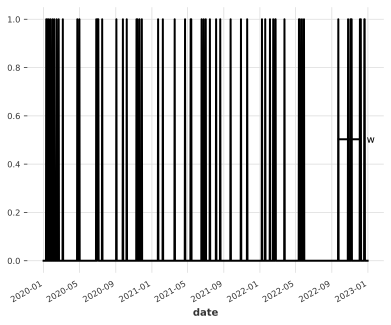

In [226]:
ts[13].plot()

In [227]:
for t in ts:
    t = t.add_datetime_attribute("weekday")
    t = t.add_holidays("DE")

In [228]:
t, c = ts[13], cov[13]
[col for col in t.static_covariates.columns if sum(t.static_covariates[col]) == 1][0]

'Bayern'

In [233]:
t.all_values().flatten().sum()

60.0

In [236]:
from darts.metrics import mse
from darts.models import NaiveSeasonal, RegressionModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

lr = LogisticRegression(
    class_weight="balanced", max_iter=1000, n_jobs=-1
)  # penalty="elasticnet"

models = [
    NaiveSeasonal(K=1),
    NaiveSeasonal(K=7),
    RegressionModel(lags=28, lags_past_covariates=28, model=lr),
]

for model in models:
    # TODO: scale
    train_length = 6 * 28 + 2
    pred_ = model.historical_forecasts(
        t,
        past_covariates=c,
        train_length=train_length,
        forecast_horizon=1,
        retrain=True,
        verbose=1,
    )
    y_pred = pred_.all_values().flatten()
    y_true = t.all_values().flatten()[train_length:]
    scores = precision_recall_fscore_support(y_true, y_pred, average="binary")
    print(model.__class__.__name__, scores)

  0%|          | 0/926 [00:00<?, ?it/s]

NaiveSeasonal (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)


  0%|          | 0/926 [00:00<?, ?it/s]

NaiveSeasonal (0.14285714285714285, 0.14285714285714285, 0.14285714285714285, None)


  0%|          | 0/926 [00:00<?, ?it/s]

RegressionModel (0.12, 0.1836734693877551, 0.14516129032258066, None)
